<a href="https://colab.research.google.com/github/tmohammad78/deep-learning-projects/blob/feature%2Fvariational-autoencoder-mnist/variational-autoencoder/mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from IPython import display

In [2]:
def encoder_layers(inputs,latent_dim):
  x = tf.keras.layers.Conv2D(filters=32,padding="same",name="encoder_conv1" , activation="relu" , kernel_size=3 , strides=2)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64,padding="same",name="encoder_conv2" , activation="relu" , kernel_size=3 , strides=2)(x)
  batch_2 = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Flatten(name="encoder_flatten")(batch_2)
  x = tf.keras.layers.Dense(20,activation="relu",name="encode_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  
  mu = tf.keras.layers.Dense(latent_dim,name="latent_mu")(x)
  sigma = tf.keras.layers.Dense(latent_dim,name="latent_sigma")(x)
  return mu , sigma , batch_2.shape

In [3]:
class Sampling(tf.keras.layers.Layer):
  def call(self,inputs):
    mu , sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
    return mu + tf.exp(0.5 * sigma) * epsilon
    

In [4]:
def encoder_model(LATENT_DIM,input_shape):
  inputs = tf.keras.layers.Input(shape=input_shape)
  mu , sigma , conv_shape = encoder_layers(inputs , latent_dim=LATENT_DIM)
  z = Sampling()((mu,sigma))
  model = tf.keras.Model(inputs,outputs=[mu,sigma,z])
  return model,conv_shape

In [5]:
def decoder_layers(inputs,conv_shape):
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units,activation="relu",name="decoder_dens1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Reshape((conv_shape[1],conv_shape[2],conv_shape[3]),name="decoder_shape")(x)
  x = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,strides=2,padding="same",activation="relu" , name="decoder_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding="same",activation="relu" , name="decoder_conv2d3")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=3,strides=1,padding="same",activation="sigmoid" , name="decoder_final")(x)
  return x

In [6]:
def decoder_model(latent_dim,conv_shape):
   inputs = tf.keras.layers.Input(shape=(latent_dim,))
   outputs = decoder_layers(inputs,conv_shape)
   model = tf.keras.Model(inputs,outputs)
   return model

In [7]:
def k1_reconstrcution_loss(output,mu , sigma):
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5


In [8]:
def vae_model(encoder, decoder , input_shape):
  inputs = tf.keras.layers.Input(shape=(input_shape))
  mu = encoder(inputs)[0]
  sigma = encoder(inputs)[1]
  z = encoder(inputs)[2]
  reconstructed = decoder(z)
  model = tf.keras.Model(inputs=inputs,outputs = reconstructed)
  loss = k1_reconstrcution_loss(z , mu , sigma)
  model.add_loss(loss)
  return model

In [9]:
def map_image(image, label):

  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28, 28, 1,))
  
  return image

def get_dataset(map_fn, is_validation=False):
 
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"

  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)
  
  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

In [10]:
def generate_and_save_images(model, epoch, step, test_input):

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      # plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

In [11]:
BATCH_SIZE=128
latent_dim = 32
train_dataset = get_dataset(map_image)
train_dataset

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [12]:
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [13]:
random_vector_for_generation = tf.random.normal(shape=[16, latent_dim])

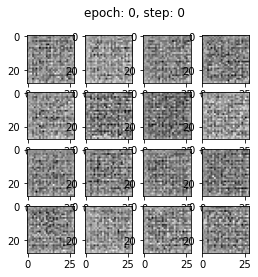

In [14]:
encoder , conv_shape = encoder_model(LATENT_DIM = 32,input_shape = (28,28,1,))
decoder = decoder_model(32,conv_shape)
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

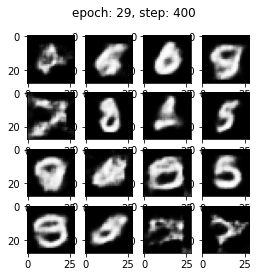

Epoch: 29 step: 400 mean loss = 95.021484
Epoch: 29 step: 401 mean loss = 95.020805
Epoch: 29 step: 402 mean loss = 95.020294
Epoch: 29 step: 403 mean loss = 95.019775
Epoch: 29 step: 404 mean loss = 95.019135
Epoch: 29 step: 405 mean loss = 95.018875
Epoch: 29 step: 406 mean loss = 95.01834
Epoch: 29 step: 407 mean loss = 95.01788
Epoch: 29 step: 408 mean loss = 95.01761
Epoch: 29 step: 409 mean loss = 95.01712
Epoch: 29 step: 410 mean loss = 95.01674
Epoch: 29 step: 411 mean loss = 95.01639
Epoch: 29 step: 412 mean loss = 95.01593
Epoch: 29 step: 413 mean loss = 95.01562
Epoch: 29 step: 414 mean loss = 95.014885
Epoch: 29 step: 415 mean loss = 95.0143
Epoch: 29 step: 416 mean loss = 95.013954
Epoch: 29 step: 417 mean loss = 95.0137
Epoch: 29 step: 418 mean loss = 95.01326
Epoch: 29 step: 419 mean loss = 95.01296
Epoch: 29 step: 420 mean loss = 95.01224
Epoch: 29 step: 421 mean loss = 95.01197
Epoch: 29 step: 422 mean loss = 95.01151
Epoch: 29 step: 423 mean loss = 95.010864
Epoch: 29

In [15]:


vae = vae_model(encoder, decoder, (28,28,1,))

vae.summary()
epochs = 30
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  for step , x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      reconstrcuted = vae(x_batch_train)
      flattened_input  = tf.reshape(x_batch_train,shape=[-1])
      flattened_output  = tf.reshape(reconstrcuted,shape=[-1])
      loss = bce_loss(flattened_input,flattened_output) * 764
      loss += sum(vae.losses)
    grads = tape.gradient(loss,vae.trainable_weights)
    optimizer.apply_gradients(zip(grads,vae.trainable_weights))
    loss_metric(loss)
    if step % 100 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
    print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))